<a href="https://colab.research.google.com/github/shobhit-umrao/NLP_Assignments/blob/master/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install pandas_ods_reader
!wget -O Hindi_Tweets.ods https://www.dropbox.com/s/7z2s5ypi7of6z9h/Hindi_Tweets.ods?dl=0

     |████████████████████████████████| 133kB 4.0MB/s 
  Created wheel for ezodf: filename=ezodf-0.3.2-py2.py3-none-any.whl size=49001 sha256=14235950455bb7422f0cf3260a79fe3e6baea0af81a41cc9dd682e303f108a24
  Stored in directory: /root/.cache/pip/wheels/c9/6c/f9/107d39d45441980bf273757eba003ef057c6193c9d7650fac7
Successfully built ezodf
--2020-09-14 05:29:12--  https://www.dropbox.com/s/7z2s5ypi7of6z9h/Hindi_Tweets.ods?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.1, 2620:100:601d:1::a27d:501
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7z2s5ypi7of6z9h/Hindi_Tweets.ods [following]
--2020-09-14 05:29:12--  https://www.dropbox.com/s/raw/7z2s5ypi7of6z9h/Hindi_Tweets.ods
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccc21cd1cde12f956a4edcc000f.dl.dropboxusercontent.com/cd/0/inline/A_XEFzy2

In [2]:
from fastai.text import *
from pandas_ods_reader import read_ods

##Model Training

In [3]:
data = read_ods("/content/Hindi_Tweets.ods",1, headers=False)

In [4]:
data.head(2)

,column_0,column_1
0,लोग वतन तक खा जाते हैं इसका इसे यकीन नहींमान ज...,negative
1,गुमनाम है वतन पर मिटने वाले लोग आतन्कवादियों स...,negative


In [5]:
table = data.copy().sample(9077, random_state=0,replace=False)
table = table[['column_0', 'column_1']]
table.dropna(inplace=True)
table[1:5000]

,column_0,column_1
3614,उन्‍होंने एक छोर संभालते हुए तेजतर्रार पारी खे...,positive
2405,RT @itsparvezsagar: शाहदरा बार एसोसिएशन के अध्...,neutral
8173,RT @aajtak: क्या राहुल गांधी दे सकते हैं मोदी ...,neutral
4319,डुमिनी ही एकमात्र ऐसे बल्लेबाज नजर आ रहे हैं ज...,negative
5322,इस चुनाव में बीजेपी ने मोदी की ब्रांडिंग करने ...,positive
...,...,...
6733,उन्होंने कहा कि अगर बकाये का भुगतान नहीं किया ...,negative
4119,शहर के बस स्टेंड से लेकर परासिया मार्ग तक ऑटो ...,negative
8042,दिन का सपना पूरा हुआ । बेटा CM हुआ । https://t...,neutral
5984,भारत एक विकासशील देश है,positive


In [6]:
data_lm = (TextList.from_df(table, cols='column_0')
 .split_by_rand_pct(0.1)
 .label_for_lm()
 .databunch())

In [7]:
data_clas = (TextList.from_df(table, cols='column_0', vocab=data_lm.vocab)
 .split_by_rand_pct(0.2)
 .label_from_df('column_1')
 .databunch())

In [8]:
data_clas.show_batch(1)

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


text,target
xxbos xxup rt @theworldindex : xxmaj world most polluted cities 2018 : \n \n 1 . 🇮 🇳 xxmaj gurugram \n 2 . 🇮 🇳 xxmaj ghaziabad \n 3 . 🇵 🇰 xxmaj faisalabad \n 4 . 🇮 🇳 xxmaj faridabad \n 5 . 🇮 🇳 xxmaj bhiwadi \n 6 . 🇮 🇳 xxmaj noida \n 7 . …,negative


In [9]:
data_lm.show_batch(2)

idx,text
0,": क्या राहुल गांधी दे सकते हैं मोदी को टक्कर , # hallabol के इस बहस में एक दिन के एंकर बने @singhrpn , देखिए शाम 6 बजे xxunk … xxbos डुमिनी ही एकमात्र ऐसे बल्लेबाज नजर आ रहे हैं जो थोड़ा बहुत लय में हैं , xxbos इस चुनाव में बीजेपी ने मोदी की xxunk करने में कोई कसर बाकी नहीं रखी है . xxbos हर साल कुछ नया"
1,\n अन्य वी … xxbos ये बताना जरूरी हो जाता है क्योंकि न बताया जाए तो फर्क समझ न आए . xxbos xxunk ने मुझे xxunk और मैं श्याम से लड़ पड़ा xxbos नए उपग्रह का प्रक्षेपण निष्फल नहीं हुआ xxbos वो xxunk xxunk xxunk में है xxunk गांधी xxunk बांधा xxunk किन्तु वो xxunk कहां है जिस पे xxunk सिंह xxunk और xxunk xxunk xxunk थे ? xxbos


In [10]:
data_lm.save('data_lm.pkl')
data_lm.vocab.itos[:3]

['xxunk', 'xxpad', 'xxbos']

In [11]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained="models/third_hi_lm.pth", drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


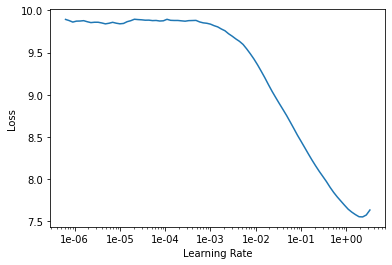

In [12]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(1, 3e-02, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


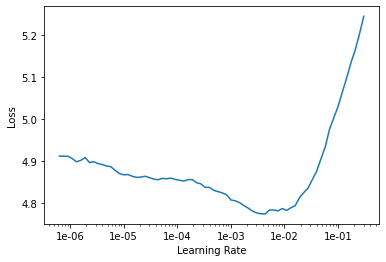

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(15, 3e-04, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.815941,4.562720,0.306875,08:33
1,4.731957,4.465684,0.311562,08:46
2,4.640402,4.363604,0.321920,09:02
3,4.547845,4.298549,0.328348,08:38
4,4.450363,4.238142,0.335446,08:34
5,4.371493,4.177215,0.341786,08:34
6,4.280356,4.125733,0.347768,08:36
7,4.193618,4.097361,0.347366,08:36
8,4.119607,4.063239,0.351429,08:45
9,4.061512,4.043187,0.352143,09:03


In [ ]:
TEXT = " में"
N_WORDS = 30
N_SENTENCES = 1

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

 में बार अब रूप का तस है । xxbos इस दृश्यों के लिए कई तरह प्रदर्शन कर दी है । xxbos RT @aajtak : # hallabol 
  दिल्ली में गढ़


In [ ]:
learn.export("models/hi_sentence.pkl")

In [ ]:
learn.save_encoder('fine_tuned_enc_9077')

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc_9077')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (7262 items)
x: TextList
xxbos उन्‍होंने एक छोर xxunk हुए xxunk पारी खेली और दिल्‍ली की जीत पर मुहर लगा दी ।,xxbos xxup rt @itsparvezsagar : शाहदरा बार एसोसिएशन के अध्यक्ष के घर हमला , बेखौफ बदमाशों का xxunk https : / / t.co / xxunk 
  - 
  @aajtak @jurmaajtak xxunk …,xxbos इस चुनाव में बीजेपी ने मोदी की xxunk करने में कोई कसर बाकी नहीं रखी है .,xxbos सरकार अब तक ज्यादा लिए गए xxunk में से महज 40 करोड़ रुपये की ही वसूली कर पाई है ।,xxbos आज से xxunk पक्ष शुरू हो रहा है अपने xxunk के नाम से जरूर दान करे और कोई भी शुभ काम या xxunk न xxunk xxunk के लिए पूजा पाठ करे # xxup xxunk
y: CategoryList
positive,neutral,positive,negative,negative
Path: .;

Valid: LabelList (1815 items)
x: TextList
xxbos यह बहुत ही xxunk xxunk है,xxbos उम्मीदवार चुनाव आयोग द्वारा तय किए गए खर्च की सीमाओं का पालन करते तो वे 3600 करोड़ से ज्यादा खर्च नहीं कर पाते , लेकिन यह आंकड़ा तो अब नामुमकिन लगता है ।,xxbos xxup rt @aajtak : सुनिए पंडित छन्नूलाल मिश्र के कंठ से 

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


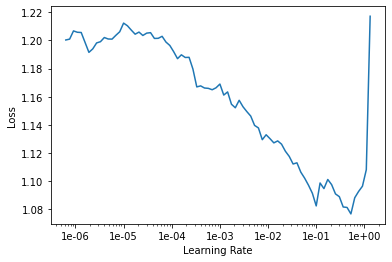

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 3e-03, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.850981,0.664161,0.683747,03:18


In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-03/(2.6**4),1e-03), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.866986,0.591399,0.705234,03:26


In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(5e-03/(2.6**4),5e-03), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.724915,0.536718,0.748209,06:49
1,0.719479,0.519029,0.749862,05:51
2,0.617007,0.491694,0.765289,06:04


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(5e-04/(2.6**4),5e-04), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.620007,0.493103,0.764187,08:33
1,0.622685,0.483518,0.772452,08:10
2,0.557205,0.459729,0.777961,08:37
3,0.550156,0.469357,0.780165,08:49
4,0.524423,0.466192,0.777410,09:17


In [ ]:
learn.fit_one_cycle(5, slice(5e-04/(2.6**4),5e-04), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.522492,0.478148,0.767493,09:42
1,0.527442,0.446189,0.785675,09:07
2,0.524803,0.443193,0.786777,08:22
3,0.476109,0.437106,0.802755,08:46
4,0.459321,0.437607,0.800551,09:16


In [ ]:
learn.export("classifier_sentiment_hi_v10.pkl")

In [ ]:
learn.predict("आज़तक पर देखिये कितनी स्मार्ट हुई स्मार्ट फेंसिंग Exclusive आज रात 9.30 pm पर @BSF_India")

(Category tensor(2), tensor(2), tensor([4.1140e-03, 1.2816e-14, 9.9589e-01]))

In [ ]:
learn.predict("चीन के सामने भारत के जांबाज़ सूरमाओं की Exclusive रिपोर्ट कोल्ड डेजर्ट के नाम से मशहूर नेलांग वैली से।… https://t.co/7JBdsL6xaE")

(Category tensor(2), tensor(2), tensor([3.2832e-03, 1.2596e-12, 9.9672e-01]))

In [ ]:
learn.predict("Female IAS officer molestation दिल्लीः साकेत कोर्ट परिसर में महिला IAS अधिकारी से छेड़छाड़ https://t.co/MtZhnAfYiV")

(Category tensor(0), tensor(0), tensor([0.3402, 0.3346, 0.3252]))

In [ ]:
from fastai.vision import *

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)

In [ ]:
inp = ClassificationInterpretation(learn,preds,y,losses)

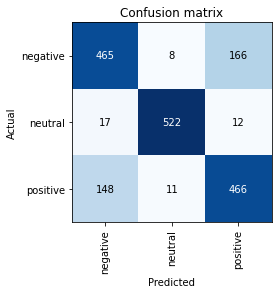

In [ ]:
inp.plot_confusion_matrix()

In [ ]:
inp.top_losses(k=1,largest=True)

torch.return_types.topk(values=tensor([6.7504]), indices=tensor([370]))

##Model Testing

In [ ]:
!wget -O Test.ods https://www.dropbox.com/s/7fdgqqzbdc4dt27/Test.ods?dl=0

--2020-09-12 16:14:43--  https://www.dropbox.com/s/7fdgqqzbdc4dt27/Test.ods?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.1, 2620:100:6030:1::a27d:5001
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7fdgqqzbdc4dt27/Test.ods [following]
--2020-09-12 16:14:44--  https://www.dropbox.com/s/raw/7fdgqqzbdc4dt27/Test.ods
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc49880df2969da70f20c2f71365.dl.dropboxusercontent.com/cd/0/inline/A_SSFfcks5SiIR-qlbT94aSAwZXSftMGHhebtwsPzKN5h4kp-eIKMkeXXy2eeoeph1cFDlRF2uJvy9A2gqRZbLPNe7yF8BYFcabfzqXHO2qYJ8mGzTiKPJ3OGD9DwdThVB8/file# [following]
--2020-09-12 16:14:44--  https://uc49880df2969da70f20c2f71365.dl.dropboxusercontent.com/cd/0/inline/A_SSFfcks5SiIR-qlbT94aSAwZXSftMGHhebtwsPzKN5h4kp-eIKMkeXXy2eeoeph1cFDlRF2uJvy9A2gqRZbLPNe7yF8BYFcabfzqXHO2qYJ8mGzTiKPJ

In [ ]:
test_pos = read_ods("Test.ods",1, headers=False)

In [ ]:
test_pos

,column_0,column_1,column_2,column_3,column_4,column_5
0,मुमकिन है कि रिलायंस कैपिटल का शेयर 330 रुपये ...,positive,बुंदेलखंड के किसानों को अबकी बार बड़ी उम्मीदें...,negative,"RT @mumbaitak: शिवसेना-बीजेपी गठबंधन में दरार,...",neutral
1,सितम्बर में इसकी कमिशिनिंग संभावित है।,positive,उन्होंने कहा कि चूंकि पूंजी की जरूरत बहुत बड़ी...,negative,"RT @mumbaitak: शिवसेना-बीजेपी गठबंधन में दरार,...",neutral
2,भारतीय कंपनी ने संभावित डील के बारे में कमेंट ...,positive,पश्चिम बंगाल में शासन द्वारा ऐसी शिकायतें लगात...,negative,RT @mumbaitak: बोरवेल में फंसे 6 साल के मासूम ...,neutral
3,हम अदालत में लड़ाई लड़ने के अलावा इस मामले को ...,positive,शहर में नेटवर्किंग कारोबार का मकड़जाल लगातार फ...,negative,RT @mumbaitak: बीजेपी-शिवसेना गठबंधन पर उद्धव ...,neutral
4,असल में कोशिश की जा रही है कि संभावित तौर पर क...,positive,हमें नहीं लगता कि आने वाले दिनों में कीमतों मे...,negative,RT @mumbaitak: ठाणे के कोरम मॉल में घुसा तेंदु...,neutral
...,...,...,...,...,...,...
680,ज्यादातर लोग गोरी बहू पसंद करते हैं,positive,हर कोई अपनी जिम्मेवारी से पल्ला झाड़ता नजर आ र...,negative,"अयोध्या में प्रियंका, कांग्रेस बजा रही ‘हिंदुत...",neutral
681,पानी रिमझिम बरस रहा है,positive,मंडी आढ़ती गेहू में घटोतरी के लिए किसी प्रकार ...,negative,RT @Shivendrak: #बहारेंहमकोढूंढेगी ⁦⁦@Akashvan...,neutral
682,यह देश आभारी है उन वीरों का जो देश की सुरक्षा ...,positive,निगम यह बात कहकर अपनी जिम्मेवारी से नहीं भाग स...,negative,राजनीति के मौसम में छूटे न कोई खबर। हर खबर है ...,neutral
683,महात्माजी बहुत तेजस्वी हैं,positive,राहुल द्रविड़ ने टीम की कमान संभाली थी और शानद...,negative,RT @AalokTweet: “किसी के पैरों पर गिर कर मंज़ि...,neutral


In [ ]:
result = []
count_pos=0
count_pos_neg=0
count_neg=0
count_neg_pos=0
count_neu=0
count_neu_pos=0
for text in test_pos.column_0:
  if str(learn.predict(str(text))[0]) == "positive":
    count_pos+=1
  if str(learn.predict(str(text))[0]) == "negative":
    count_pos_neg+=1
    
for text in test_pos.column_2:
  if str(learn.predict(str(text))[0]) == "negative":
    count_neg+=1
  if str(learn.predict(str(text))[0]) == "positive":
    count_neg_pos+=1
    
for text in test_pos.column_4:
  if str(learn.predict(str(text))[0]) == "neutral":
    count_neu+=1
  if str(learn.predict(str(text))[0]) == "positive":
    count_neu_pos+=1

Positive Set

In [ ]:
count_pos/686 , count_pos_neg/686 , 1-count_pos/686-count_pos_neg/686

Neutral Set

In [ ]:
count_neu/686 , count_neu_pos/686 , 1-count_neu/686-count_neu_pos/686

Negative Set

In [ ]:
count_neg/686 , count_neg_pos/686 , 1-count_neg/686-count_neg_pos/686